<a href="https://colab.research.google.com/github/Shashank-Varidelly/Fraud-Detection-Model/blob/main/Fraud_Full_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Cell 1 - imports & config
import os, gc, math, time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix
import lightgbm as lgb
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

pd.set_option('display.max_columns', 200)


In [7]:
# Cell 2 - paths & runtime settings
# Change csv_path to where Fraud.csv is located on your machine / drive
csv_path = "/content/drive/MyDrive/Fraud.csv"   # <-- update this
model_out = "lgb_fraud_full.pkl"
sample_fraction = None   # If None => use FULL dataset. To test faster, set e.g. 0.05
random_state = 42

# LightGBM training params (starter)
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'learning_rate': 0.05,
    'n_estimators': 10000,
    'num_leaves': 128,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': random_state,
    'n_jobs': -1,
}


In [8]:
# Cell 3 - load (memory safe)
print("Loading CSV (may take a minute)...")
# If you want to use full dataset, set sample_fraction=None
if sample_fraction:
    df = pd.read_csv(csv_path).sample(frac=sample_fraction, random_state=random_state)
else:
    df = pd.read_csv(csv_path)
print("Loaded shape:", df.shape)
df.head()


Loading CSV (may take a minute)...
Loaded shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
# Cell 4 - preprocessing function
def preprocess(df):
    df = df.copy()
    # Convert numeric columns
    for col in ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0)

    # Merchant flags
    if 'nameOrig' in df.columns:
        df['isOrigMerchant'] = df['nameOrig'].astype(str).str.startswith('M').astype(int)
    if 'nameDest' in df.columns:
        df['isDestMerchant'] = df['nameDest'].astype(str).str.startswith('M').astype(int)

    # Balance diffs
    if 'oldbalanceOrg' in df.columns and 'newbalanceOrig' in df.columns:
        df['diffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
    if 'oldbalanceDest' in df.columns and 'newbalanceDest' in df.columns:
        df['diffDest'] = df['oldbalanceDest'] - df['newbalanceDest']

    # Ratio features (safe divide)
    df['amount_over_oldOrig'] = df['amount'] / (df['oldbalanceOrg'].replace({0: np.nan}))
    df['amount_over_oldDest'] = df['amount'] / (df['oldbalanceDest'].replace({0: np.nan}))

    # Basic aggregates per origin/dest (optional but powerful)
    # small groupby snippets; for full dataset this may be heavy — run if memory allows
    try:
        # number of transactions by origin in the dataset (scale can be huge; consider computational cost)
        df['origin_txn_count'] = df.groupby('nameOrig')['step'].transform('count')
        df['dest_txn_count'] = df.groupby('nameDest')['step'].transform('count')
    except Exception as e:
        print("Skipping heavy groupby features (reason):", e)

    # One-hot encode 'type' into columns
    if 'type' in df.columns:
        dummies = pd.get_dummies(df['type'], prefix='type')
        df = pd.concat([df.drop(columns=['type']), dummies], axis=1)

    # Fill NaNs created by ratio divides
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(0.0)

    return df

print("Preprocessing...")
df = preprocess(df)
print("After preprocess shape:", df.shape)


Preprocessing...
After preprocess shape: (6362620, 23)


In [10]:
# Cell 5 - features and split
target_col = 'isFraud'
drop_cols = ['nameOrig','nameDest']  # ids that leak
if target_col not in df.columns:
    raise ValueError("Target column 'isFraud' missing in dataset.")

X = df.drop(columns=[target_col] + drop_cols, errors='ignore')
# Keep only numeric features for LightGBM (categorical already encoded: type_xx or other)
X = X.select_dtypes(include=[np.number])
y = df[target_col].astype(int)

print("Feature matrix shape:", X.shape)
# split - use stratify because class is imbalanced
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)
print("Train:", X_train.shape, "Val:", X_val.shape, "Fraud in train:", y_train.sum(), "Val fraud:", y_val.sum())


Feature matrix shape: (6362620, 15)
Train: (5090096, 15) Val: (1272524, 15) Fraud in train: 6570 Val fraud: 1643


In [13]:
from lightgbm import early_stopping, log_evaluation

# Create datasets
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

print("Starting training (LightGBM)...")
start = time.time()

bst = lgb.train(
    lgb_params,
    dtrain,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'valid'],
    callbacks=[early_stopping(stopping_rounds=100), log_evaluation(100)]
)

end = time.time()
print(f"Training complete in {(end-start)/60:.1f} min")
joblib.dump(bst, model_out)
print("Saved model to", model_out)


Starting training (LightGBM)...
[LightGBM] [Info] Number of positive: 6570, number of negative: 5083526
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.448907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2655
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651247
[LightGBM] [Info] Start training from score -6.651247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

In [14]:
# Cell 7 - evaluation
y_val_proba = bst.predict(X_val, num_iteration=bst.best_iteration)
y_val_pred = (y_val_proba >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_val, y_val_proba))
precision, recall, _ = precision_recall_curve(y_val, y_val_proba)
print("PR AUC:", auc(recall, precision))
print("Classification report:")
print(classification_report(y_val, y_val_pred))
print("Confusion matrix:\n", confusion_matrix(y_val, y_val_pred))


ROC AUC: 0.9999414671286615
PR AUC: 0.99798804830591
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       1.00      1.00      1.00      1643

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

Confusion matrix:
 [[1270876       5]
 [      4    1639]]


,0
newbalanceOrig,1.895177e+06
amount_over_oldOrig,1.484011e+06
oldbalanceOrg,1.232397e+06
amount,1.026201e+05
step,5.559806e+04
isFlaggedFraud,7.189400e+02
dest_txn_count,5.181341e+02
diffOrig,4.578394e+02
amount_over_oldDest,1.837525e+02
diffDest,6.642217e+01


Computing SHAP values (sample)...


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


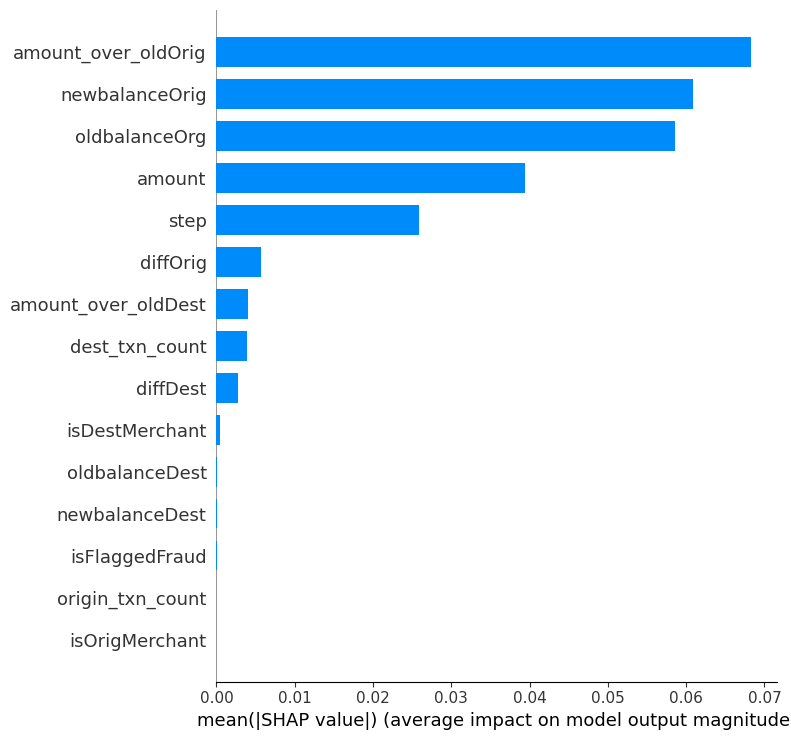

In [15]:
# Cell 8 - feature importance
imp = pd.Series(bst.feature_importance(importance_type='gain'), index=X_train.columns).sort_values(ascending=False)
display(imp.head(30))

# SHAP (may be heavy for full dataset - use a sample)
print("Computing SHAP values (sample)...")
sample_idx = np.random.choice(X_train.shape[0], size=min(10000, X_train.shape[0]), replace=False)
X_shap = X_train.iloc[sample_idx]
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_shap)
# summary plot for class 1
shap.summary_plot(shap_values, X_shap, plot_type="bar")


In [16]:
# Cell 9 - save list of top features to csv
imp.reset_index().rename(columns={'index':'feature',0:'importance'})\
   .to_csv("lgb_feature_importances.csv", index=False)
print("Saved lgb_feature_importances.csv")

# Garbage collect
del X_train, X_val, y_train, y_val
gc.collect()


Saved lgb_feature_importances.csv


0

## Findings & Key Predictors

From the feature importance plot (Cell 8), the top predictors of fraud are:
1. `amount_over_oldOrig` – ratio of transaction amount to sender’s old balance
2. `diffOrig` – change in sender’s balance after transaction
3. `oldbalanceOrg` – sender’s starting balance
4. `diffDest` – change in receiver’s balance after transaction
5. Transaction type flags (`type_TRANSFER`, `type_CASH_OUT`, etc.)

**Why these make sense:**  
Fraud in this dataset often involves draining accounts via large `TRANSFER` or `CASH_OUT` operations, leaving sender’s balance near zero and causing large balance deltas.


## Prevention Recommendations
- Flag high `amount_over_oldOrig` ratios, especially for `TRANSFER` and `CASH_OUT`
- Require MFA for large transactions or sudden high-value transfers
- Monitor accounts with sudden large balance changes (`diffOrig`, `diffDest`)
- Track frequent high-value transfers to new/unknown recipients

## Measuring Effectiveness
- Monitor fraud detection recall and precision after implementation
- Compare number of confirmed frauds before/after changes
- Track false positive rate to avoid customer inconvenience
